In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

"""date      , hh,min,ss      ,startfreq,end freq , ignore , ignore, 6:2006 (2001 values of freq)"""

###Step 1: Process Input file from csv with format above to produce Spectrogram images 
###and store them in NumPy Arrays - reGenImage and reGenData respectively
#### IMPORTANT: MIGHT RUN OUT OF RAM HERE! If this happens, just run for each gainFile and 
#### dont automate across different gainFile

folder = 'rfData/DTTA_L22_2100H/'
for gainFile in os.listdir(folder):
	filePath = folder+gainFile
	destPath = 'reGenData/DTTA_L22_2100H/' +gainFile
	destImgPath = 'reGenImage/DTTA_L22_2100H/' +gainFile
	if(not os.path.isdir(destPath)):
			os.mkdir(destPath)
	if(not os.path.isdir(destImgPath)):
			os.mkdir(destImgPath)

	## We order the files in ascending order
	minList = []
	Filelist = os.listdir(filePath)
	for file in Filelist:
		minList.append(int(file.split('-')[0]))
	Filearray = np.array(Filelist)
	orderedFiles = Filearray[np.argsort(minList)].tolist()[::-1]
	print(orderedFiles)




	for file in orderedFiles:
		dataPath = os.path.join(filePath,file)
		print("###### Opening file:", dataPath)
		df = pd.read_csv(dataPath,
			index_col = None, 
			header = None, 
			sep =',')

		df = df.head(10000) # Get first ~500 time samples
		numRows = df.iloc[:,1].nunique()
		print("Number of Time samples:", numRows)

		minFreq = int(file.split('-')[0])
		maxFreq = int(file.split('-')[1].split('.')[0])

		spectral = np.empty((numRows,2001*(maxFreq-minFreq)//5))

		timeSeen = []
		timeCount = 0
		background = np.ones(2001)*-75

		

		destPic = os.path.join(destImgPath,file.split('.')[0] + '.png')
		destNp =  os.path.join(destPath,file.split('.')[0])

		#Reorder frequency of input data and fill empty values with that of background
		for time in df.iloc[:,1]:
			if time not in timeSeen:
				powerAtTime = []
				dfTime = df[(df.iloc[:,1] == time)]
				for freq in range(minFreq*1000000,maxFreq*1000000,5*1000000):
					dfFreq = dfTime[(dfTime.iloc[:,2] == freq)]
					if(dfFreq.empty):
						powerAtTime.extend(background.tolist())
					else:
						powerAtTime.extend(dfFreq.values[0,6:2007].tolist())
				
				spectral[timeCount,:] = np.array(powerAtTime).T
				timeCount = timeCount+1

				timeSeen.append(time)

		fig = plt.figure()
		plot = plt.pcolormesh(spectral,cmap = 'gnuplot',vmin = -82, vmax = -35)
		plt.colorbar()
		plt.savefig(destPic)
		plt.close(fig)
		
		np.save(destNp,spectral)
		del spectral

['2600-2700.txt', '2500-2600.txt', '2400-2500.txt', '2300-2400.txt', '2200-2300.txt', '2100-2200.txt', '2000-2100.txt', '1900-2000.txt', '1800-1900.txt', '1700-1800.txt', '1600-1700.txt', '1500-1600.txt', '1400-1500.txt', '1300-1400.txt', '1200-1300.txt', '1100-1200.txt', '1000-1100.txt', '900-1000.txt', '800-900.txt', '700-800.txt', '600-700.txt', '500-600.txt', '400-500.txt', '300-400.txt', '200-300.txt', '100-200.txt', '50-100.txt']
###### Opening file: rfData/DTTA_L22_2100H/l16g10/2600-2700.txt
Number of Time samples: 500
###### Opening file: rfData/DTTA_L22_2100H/l16g10/2500-2600.txt
Number of Time samples: 500
###### Opening file: rfData/DTTA_L22_2100H/l16g10/2400-2500.txt
Number of Time samples: 468
###### Opening file: rfData/DTTA_L22_2100H/l16g10/2300-2400.txt
Number of Time samples: 500
###### Opening file: rfData/DTTA_L22_2100H/l16g10/2200-2300.txt
Number of Time samples: 500
###### Opening file: rfData/DTTA_L22_2100H/l16g10/2100-2200.txt
Number of Time samples: 467
###### O

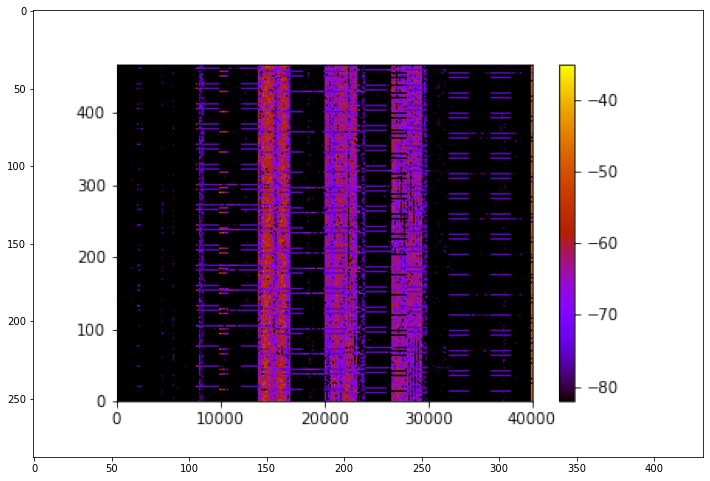

In [2]:
##Visualisation of regenData
import matplotlib.pyplot as plt
%matplotlib inline

reGenImage = plt.imread('reGenImage/DTTA_L22_2100H/l16g10/500-600.png')  ##Image below is for 500-600 MHz
plt.figure(figsize=(12,15))
imgplot = plt.imshow(reGenImage)
plt.show()

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Step 2: Find start and end frequencies and then trim spectral images based on number of timeIntervals defined below
"""date      , hh,min,ss      ,startfreq,end freq , ignore , ignore, 6:2006 (2001 values of freq)"""
"""500-600.npy, 800-900.npy, 2600-2700.npy,  2100-2200.npy, 2300-2400.npy,  lookahead = 100, abs =17"""
"""2500-2600.npy, lookahead =100,abs =15,max"""


"""Didnt work well : 2500-2600.npy, 2400-2500"""

npfile = '500-600.npy'
textFile = 'reGenData/DTTA_L12_2000H/l32g10/' + npfile 
lookahead = 100
threshold =17
minFreq = int(npfile.split('-')[0])
maxFreq = int(npfile.split('-')[1].split('.')[0])

locateSpectral = np.load(textFile)
print("####Spectral search on: ", textFile, "with shape: ",locateSpectral.shape)

specMean = np.mean(locateSpectral,axis=0) #Average spectrum across time axis
diffSpec =specMean[lookahead:] - specMean[:-lookahead]
bins = diffSpec.shape[0]
prevIndx = 0
waitStart = True

listSignals =[]
listFreq = []

##Algo to find pairs of start,end frequencies
for num,i in enumerate(diffSpec):
	if(abs(i) > threshold):
		if(i>0 and (num  > prevIndx+lookahead-1) and waitStart):
			startFreq = (num+lookahead)/bins*(maxFreq-minFreq)+minFreq
			startIdx = num+lookahead
			#print("Start of Bandwidth",i,"Freq:",startFreq)
			prevIndx = num
			waitStart = False
			

		elif(i<0 and (num  > prevIndx+lookahead-1) and not waitStart):
			endFreq = (num+lookahead)/bins*(maxFreq-minFreq)+minFreq
			endIdx = num+lookahead
			#print("End of Bandwidth",i,"Freq:",endFreq)
			prevIndx = num
			waitStart = True
			
			if(endFreq-startFreq>5):
				listSignals.append((startIdx,endIdx))
				listFreq.append((int(startFreq),int(endFreq)))
				print("Signal identified between:", startFreq, "and" , endFreq )

#Once spectral bands found, trim and save the spectral image:
timeIntervals =25
saveDest ='newTrain/'

for timeDate in os.listdir('reGenData/'):
	timeDateDir = os.path.join('reGenData',timeDate)
	for gain in os.listdir(timeDateDir):
		gainDir = os.path.join(timeDateDir,gain)
		NUMPYFILE = os.path.join(gainDir,npfile)
		spectral = np.load(NUMPYFILE)
		print("Loaded:", NUMPYFILE)

		for signalRange in listSignals:
			startFreq = int(signalRange[0]/bins*(maxFreq-minFreq)+minFreq)
			endFreq = int(signalRange[1]/bins*(maxFreq-minFreq)+minFreq)
			folderDest = saveDest +str(startFreq) +'-' +str(endFreq) 
			if(not os.path.isdir(folderDest)):
				os.mkdir(folderDest)

			print("Trimming Spectrum Frequency:", startFreq, " to ", endFreq)

			midPoint = (signalRange[0] +signalRange[1])//2
			startBand, endBand = max(midPoint-4000,0), min(midPoint+4000,40019)
			for timeStart in range(0,spectral.shape[0]-timeIntervals,timeIntervals):
				print("time:",timeStart)
				fig = plt.figure()		
				plt.pcolormesh(spectral[timeStart:timeStart+timeIntervals,startBand:endBand],
                               cmap = 'gnuplot',vmin = -82, vmax = -35)
				plt.axis('off')
				plt.savefig(os.path.join(folderDest,timeDate+'-'+gain+'_'+str(timeStart)+".png"))
				plt.close(fig)


	

####Spectral search on:  reGenData/DTTA_L12_2000H/l32g10/500-600.npy with shape:  (468, 40020)
Signal identified between: 534.2009018036072 and 540.3481963927856
Signal identified between: 550.122745490982 and 560.3957915831663
Signal identified between: 566.3426853707415 and 580.4458917835672
Loaded: reGenData/DTTA_L12_1100H/l24g6/500-600.npy
Trimming Spectrum Frequency: 534  to  540
time: 0
time: 25
time: 50
time: 75
time: 100
time: 125
time: 150
time: 175
time: 200
time: 225
time: 250
time: 275
time: 300
time: 325
time: 350
time: 375
time: 400
time: 425
Trimming Spectrum Frequency: 550  to  560
time: 0
time: 25
time: 50
time: 75
time: 100
time: 125
time: 150
time: 175
time: 200
time: 225
time: 250
time: 275
time: 300
time: 325
time: 350
time: 375
time: 400
time: 425
Trimming Spectrum Frequency: 566  to  580
time: 0
time: 25
time: 50
time: 75
time: 100
time: 125
time: 150
time: 175
time: 200
time: 225
time: 250
time: 275
time: 300
time: 325
time: 350
time: 375
time: 400
time: 425
Loa

time: 50
time: 75
time: 100
time: 125
time: 150
time: 175
time: 200
time: 225
time: 250
time: 275
time: 300
time: 325
time: 350
time: 375
time: 400
time: 425
Trimming Spectrum Frequency: 550  to  560
time: 0
time: 25
time: 50
time: 75
time: 100
time: 125
time: 150
time: 175
time: 200
time: 225
time: 250
time: 275
time: 300
time: 325
time: 350
time: 375
time: 400
time: 425
Trimming Spectrum Frequency: 566  to  580
time: 0
time: 25
time: 50
time: 75
time: 100
time: 125
time: 150
time: 175
time: 200
time: 225
time: 250
time: 275
time: 300
time: 325
time: 350
time: 375
time: 400
time: 425
Loaded: reGenData/DTTA_L22_2100H/l24g6/500-600.npy
Trimming Spectrum Frequency: 534  to  540
time: 0
time: 25
time: 50
time: 75
time: 100
time: 125
time: 150
time: 175
time: 200
time: 225
time: 250
time: 275
time: 300
time: 325
time: 350
time: 375
time: 400
time: 425
Trimming Spectrum Frequency: 550  to  560
time: 0
time: 25
time: 50
time: 75
time: 100
time: 125
time: 150
time: 175
time: 200
time: 225
tim

In [1]:
from keras.models import Sequential,Model,load_model
from keras.optimizers import SGD,Adam
from keras.layers import BatchNormalization, Lambda, Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.merge import Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto, InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.99
sess = InteractiveSession(config=config)


def signal_net(num_classes):
    # placeholder for input image
    input_image = Input(shape=(224,224,3))
    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(227,227,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=2048, activation='relu')(flatten)
    FC_1 = Dropout(0.3)(FC_1)
    FC_2 = Dense(units=1024, activation='relu')(FC_1)
    FC_2 = Dropout(0.3)(FC_2)
    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    sgd = SGD(lr=5e-4, decay=5e-7, momentum=0.9, nesterov=True)
    #adam = Adam()
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def vgg16_net(num_classes):
    input_image = Input(shape=(224,224,3))
    # ============================================= Convolution Blocks ===================================================
    top_conv1 = Convolution2D(filters=48,kernel_size=(3,3), padding="same", input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = Convolution2D(filters=48,kernel_size=(3,3), padding="same",activation='relu')(top_conv1)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(top_conv1)

    top_conv2 = Convolution2D(filters=96,kernel_size=(3,3), padding="same",activation='relu')(top_conv1)
    top_conv2 = BatchNormalization()(top_conv2)
    top_conv2 = Convolution2D(filters=96,kernel_size=(3,3), padding="same",activation='relu')(top_conv2)
    top_conv2 = BatchNormalization()(top_conv2)
    top_conv2 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(top_conv2)

    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),padding="same",activation='relu')(top_conv2)
    top_conv3 = BatchNormalization()(top_conv3)
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),padding="same",activation='relu')(top_conv3)
    top_conv3 = BatchNormalization()(top_conv3)
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),padding="same",activation='relu')(top_conv3)
    top_conv3 = BatchNormalization()(top_conv3)
    top_conv3 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(top_conv3)

    top_conv4 = Convolution2D(filters=384,kernel_size=(3,3),padding="same",activation='relu')(top_conv3)
    top_conv4 = BatchNormalization()(top_conv4)
    top_conv4 = Convolution2D(filters=384,kernel_size=(3,3),padding="same",activation='relu')(top_conv4)
    top_conv4 = BatchNormalization()(top_conv4)
    top_conv4 = Convolution2D(filters=384,kernel_size=(3,3),padding="same",activation='relu')(top_conv4)
    top_conv4 = BatchNormalization()(top_conv4)
    top_conv4 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(top_conv4)

    top_conv5 = Convolution2D(filters=384,kernel_size=(3,3),padding="same",activation='relu')(top_conv4)
    top_conv5 = BatchNormalization()(top_conv5)
    top_conv5 = Convolution2D(filters=384,kernel_size=(3,3),padding="same",activation='relu')(top_conv5)
    top_conv5 = BatchNormalization()(top_conv5)
    top_conv5 = Convolution2D(filters=384,kernel_size=(3,3),padding="same",activation='relu')(top_conv5)
    top_conv5 = BatchNormalization()(top_conv5)
    top_conv5 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(top_conv5)


    # ======================================== FC Layers =================================
    # Flatten
    flatten = Flatten()(top_conv5)

    # Fully-connected layer
    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.3)(FC_1)
    FC_2 = Dense(units=2048, activation='relu')(FC_1)
    FC_2 = Dropout(0.3)(FC_2)
    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    sgd = SGD(lr=5e-4, decay=5e-7, momentum=0.9, nesterov=True)
    adam = Adam()
    # sgd = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model


img_rows , img_cols = 224,224
num_classes = 11
batch_size = 8
nb_epoch = 25

# initialise model
model = vgg16_net(num_classes)


train_datagen = ImageDataGenerator(dtype='float32',validation_split=0.2)

#test_datagen = ImageDataGenerator(dtype='float32')

training_set = train_datagen.flow_from_directory(
            'newTrain/',
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical',
            subset = 'training')

validation_set = train_datagen.flow_from_directory(
            'newTrain/',
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical',
            subset = 'validation')

print(training_set.samples)
print(validation_set.samples)



history = model.fit_generator(
        training_set,
        steps_per_epoch = training_set.samples//batch_size,
        validation_data = validation_set,
        validation_steps =  validation_set.samples//batch_size,
        epochs=nb_epoch,
        callbacks=[ModelCheckpoint('vgg16_modeltest_sgd.h5',
                        monitor ='val_loss',
                        verbose = 1,
                        save_best_only = True,
                        save_weights_only = False,
                        mode = 'min',
                        period = 1)])

/home/kayne/anaconda3/envs/tf2.2/lib/python3.8/site-packages/tensorflow/python/ops/random_ops.py:285: SyntaxWarning: "is" with a literal. Did you mean "=="?
  minval_is_zero = minval is 0  # pylint: disable=literal-comparison
/home/kayne/anaconda3/envs/tf2.2/lib/python3.8/site-packages/tensorflow/python/ops/random_ops.py:286: SyntaxWarning: "is" with a literal. Did you mean "=="?
  maxval_is_one = maxval is 1  # pylint: disable=literal-comparison
/home/kayne/anaconda3/envs/tf2.2/lib/python3.8/site-packages/tensorflow/python/ops/ragged/ragged_batch_gather_with_default_op.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (default_value.shape.ndims is not 0
/home/kayne/anaconda3/envs/tf2.2/lib/python3.8/site-packages/tensorflow/python/ops/ragged/ragged_batch_gather_with_default_op.py:85: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  and default_value.shape.ndims is not 1):


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 48)      1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 48)      192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 48)      20784     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 48)      192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 48)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 96)      41568 

Epoch 9/25
407/407 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9902
Epoch 00009: val_loss did not improve from 0.39103
407/407 [==============================] - 41s 100ms/step - loss: 0.0250 - accuracy: 0.9902 - val_loss: 0.8055 - val_accuracy: 0.8676
Epoch 10/25
407/407 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9892
Epoch 00010: val_loss improved from 0.39103 to 0.37127, saving model to vgg16_modeltest_sgd.h5
407/407 [==============================] - 42s 104ms/step - loss: 0.0319 - accuracy: 0.9892 - val_loss: 0.3713 - val_accuracy: 0.9257
Epoch 11/25
407/407 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9932
Epoch 00011: val_loss did not improve from 0.37127
407/407 [==============================] - 41s 100ms/step - loss: 0.0190 - accuracy: 0.9932 - val_loss: 0.6510 - val_accuracy: 0.9233
Epoch 12/25
407/407 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9942
Epoch 00012: v

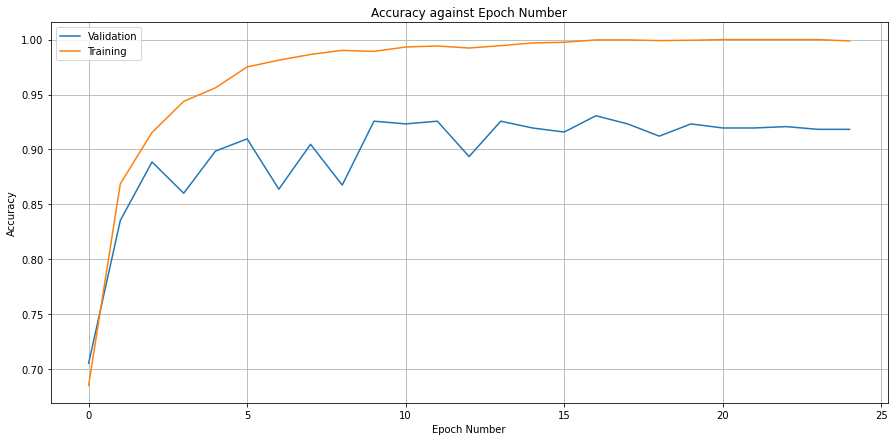

In [5]:
plt.figure(figsize=(15,7))
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.legend(['Validation','Training'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy against Epoch Number')
plt.grid()
plt.show()